This is a modified notebook for the project, from the sample code downloaded originally from MedMNIST example at https://github.com/MedMNIST/MedMNIST/blob/main/examples/getting_started.ipynb .

In [1]:
!pip install medmnist


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

# Device setup
# Check for CUDA
if torch.cuda.is_available():
	device = torch.device("cuda")
	print("Using CUDA (GPU)")

	
# Check for MPS (Apple Silicon Macs)
elif torch.backends.mps.is_available():
	device = torch.device("mps")
	print("Using MPS (macOS)")
	
else:
	device = torch.device("cpu")
	print("Using CPU")

# Example usage: Move model and tensors to the selected device

import medmnist
from medmnist import INFO, Evaluator

Using CUDA (GPU)


In [3]:
print(f"MedMNIST v{medmnist.__version__} @ {medmnist.HOMEPAGE}")

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/


# We first work on a 2D dataset with size 28x28

In [4]:
data_flag = 'pathmnist'
# data_flag = 'breastmnist'
download = True

NUM_EPOCHS = 3
BATCH_SIZE = 128
lr = 0.001

info = INFO[data_flag]
task = info['task']
n_channels = info['n_channels']
n_classes = len(info['label'])

DataClass = getattr(medmnist, info['python_class'])

## First, we read the MedMNIST data, preprocess them and encapsulate them into dataloader form.

In [5]:
DOWNLOAD_PATH = "D:\.medmnist"

<>:1: SyntaxWarning: invalid escape sequence '\.'
<>:1: SyntaxWarning: invalid escape sequence '\.'
C:\Users\12469\AppData\Local\Temp\ipykernel_38536\2857758383.py:1: SyntaxWarning: invalid escape sequence '\.'
  DOWNLOAD_PATH = "D:\.medmnist"


In [6]:
# preprocessing
data_transform = transforms.Compose([
	transforms.ToTensor(),
	transforms.Normalize(mean=[.5], std=[.5])
])

# load the data
train_dataset = DataClass(root = DOWNLOAD_PATH, split='train', transform=data_transform, download=download)
test_dataset = DataClass(root = DOWNLOAD_PATH, split='test', transform=data_transform, download=download)

pil_dataset = DataClass(root = DOWNLOAD_PATH, split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [9]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 28 (pathmnist)
    Number of datapoints: 89996
    Root location: D:\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-100K in

In [7]:
# visualization

train_dataset.montage(length=1)

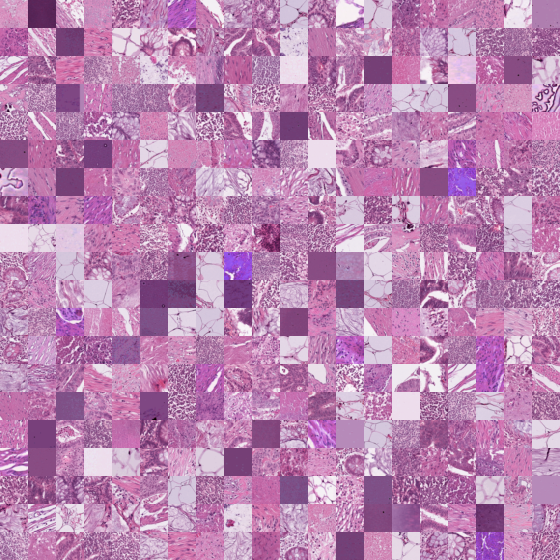

In [8]:
# montage

train_dataset.montage(length=20)

## Then, we define a simple model for illustration, object function and optimizer that we use to classify.

In [10]:
# define a simple CNN model

class Net(nn.Module):
	def __init__(self, in_channels, num_classes):
		super(Net, self).__init__()

		self.layer1 = nn.Sequential(
			nn.Conv2d(in_channels, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU())

		self.layer2 = nn.Sequential(
			nn.Conv2d(16, 16, kernel_size=3),
			nn.BatchNorm2d(16),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.layer3 = nn.Sequential(
			nn.Conv2d(16, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())
		
		self.layer4 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3),
			nn.BatchNorm2d(64),
			nn.ReLU())

		self.layer5 = nn.Sequential(
			nn.Conv2d(64, 64, kernel_size=3, padding=1),
			nn.BatchNorm2d(64),
			nn.ReLU(),
			nn.MaxPool2d(kernel_size=2, stride=2))

		self.fc = nn.Sequential(
			nn.Linear(64 * 4 * 4, 128),
			nn.ReLU(),
			nn.Linear(128, 128),
			nn.ReLU(),
			nn.Linear(128, num_classes))

	def forward(self, x):
		x = self.layer1(x)
		x = self.layer2(x)
		x = self.layer3(x)
		x = self.layer4(x)
		x = self.layer5(x)
		x = x.view(x.size(0), -1)
		x = self.fc(x)
		return x

model = Net(in_channels=n_channels, num_classes=n_classes).to(device)
	
# define loss function and optimizer
if task == "multi-label, binary-class":
	criterion = nn.BCEWithLogitsLoss()
else:
	criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

## Next, we can start to train and evaluate!

In [11]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()

 41%|████      | 290/704 [00:05<00:07, 56.15it/s]


KeyboardInterrupt: 

In [11]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.986  acc:0.840
test  auc: 0.956  acc:0.758


# We then check a 2D dataset with size 224x224

In [7]:
data_flag = 'pathmnist'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
# train_dataset = DataClass(split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
train_dataset = DataClass(root = DOWNLOAD_PATH, split='train', transform=data_transform, download=download, size=224, mmap_mode='r')
test_dataset = DataClass(root = DOWNLOAD_PATH, split='test', transform=data_transform, download=download, size=224, mmap_mode='r')

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
train_loader_at_eval = data.DataLoader(dataset=train_dataset, batch_size=2*BATCH_SIZE, shuffle=False)
test_loader = data.DataLoader(dataset=test_dataset, batch_size=2*BATCH_SIZE, shuffle=False)

In [ ]:
print(train_dataset)
print("===================")
print(test_dataset)

Dataset PathMNIST of size 224 (pathmnist_224)
    Number of datapoints: 89996
    Root location: D:\.medmnist
    Split: train
    Task: multi-class
    Number of channels: 3
    Meaning of labels: {'0': 'adipose', '1': 'background', '2': 'debris', '3': 'lymphocytes', '4': 'mucus', '5': 'smooth muscle', '6': 'normal colon mucosa', '7': 'cancer-associated stroma', '8': 'colorectal adenocarcinoma epithelium'}
    Number of samples: {'train': 89996, 'val': 10004, 'test': 7180}
    Description: The PathMNIST is based on a prior study for predicting survival from colorectal cancer histology slides, providing a dataset (NCT-CRC-HE-100K) of 100,000 non-overlapping image patches from hematoxylin & eosin stained histological images, and a test dataset (CRC-VAL-HE-7K) of 7,180 image patches from a different clinical center. The dataset is comprised of 9 types of tissues, resulting in a multi-class classification task. We resize the source images of 3×224×224 into 3×28×28, and split NCT-CRC-HE-10

In [24]:
x, y = train_dataset[0]

print(x.shape, y.shape)

torch.Size([3, 224, 224]) (1,)


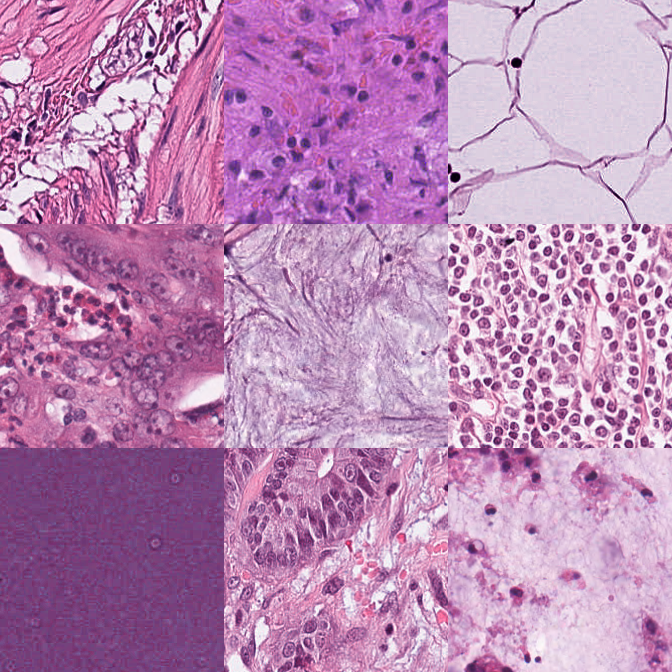

In [46]:
train_dataset.montage(length=3)

## Then we train and evaluate on this 224x224 dataset

In [ ]:
from torchvision.models import resnet18

model = resnet18(num_classes=n_classes).to(device)

criterion = nn.CrossEntropyLoss()
	
optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)

In [13]:
# train

for epoch in range(NUM_EPOCHS):
	train_correct = 0
	train_total = 0
	test_correct = 0
	test_total = 0
	
	model.train()
	for inputs, targets in tqdm(train_loader):
		# forward + backward + optimize 
		inputs, targets = inputs.to(device), targets.to(device)
		optimizer.zero_grad()
		outputs = model(inputs)
		
		if task == 'multi-label, binary-class':
			targets = targets.to(torch.float32)
			loss = criterion(outputs, targets)
		else:
			targets = targets.squeeze().long()
			loss = criterion(outputs, targets)
		
		loss.backward()
		optimizer.step()
		
torch.save(model.state_dict(), 'trained_model.pth')

100%|██████████| 704/704 [02:53<00:00,  4.06it/s]


## Load Model ##

In [ ]:
model = resnet18(num_classes=n_classes).to(device)
model.load_state_dict(torch.load('trained_model.pth'))
model.eval()  

In [29]:
# evaluation

def test(split):
	model.eval()
	y_true = torch.tensor([], device=device)
	y_score = torch.tensor([], device=device)
	
	data_loader = train_loader_at_eval if split == 'train' else test_loader

	with torch.no_grad():
		for inputs, targets in data_loader:
			inputs, targets = inputs.to(device), targets.to(device)
			outputs = model(inputs)

			if task == 'multi-label, binary-class':
				targets = targets.to(torch.float32)
				outputs = outputs.softmax(dim=-1)
			else:
				targets = targets.squeeze().long()
				outputs = outputs.softmax(dim=-1)
				targets = targets.float().resize_(len(targets), 1)

			y_true = torch.cat((y_true, targets), 0)
			y_score = torch.cat((y_score, outputs), 0)

		y_true = y_true.cpu().numpy()
		y_score = y_score.cpu().detach().numpy()
		
		evaluator = Evaluator(data_flag, split)
		metrics = evaluator.evaluate(y_score)
	
		print('%s  auc: %.3f  acc:%.3f' % (split, *metrics))

		
print('==> Evaluating ...')
test('train')
test('test')

==> Evaluating ...
train  auc: 0.998  acc:0.950
test  auc: 0.969  acc:0.833


In [14]:
# 访问图像和标签
images = test_dataset.imgs[0]  # 图像数据，形状为 (N, H, W, C)
labels = test_dataset.labels  # 标签数据，形状为 (N,)

# 检查类型
print(images.shape)  # <class 'numpy.ndarray'>
print(type(labels))  # <class 'numpy.ndarray'>

(224, 224, 3)
<class 'numpy.ndarray'>


In [15]:
label_mapping = info['label']

output_names = [label_mapping[str(i)] for i in range(len(label_mapping))]

test_images = test_dataset.imgs 

test_labels = test_dataset.labels

PartitionExplainer explainer: 2it [00:12, 12.40s/it]               


True Label:  debris


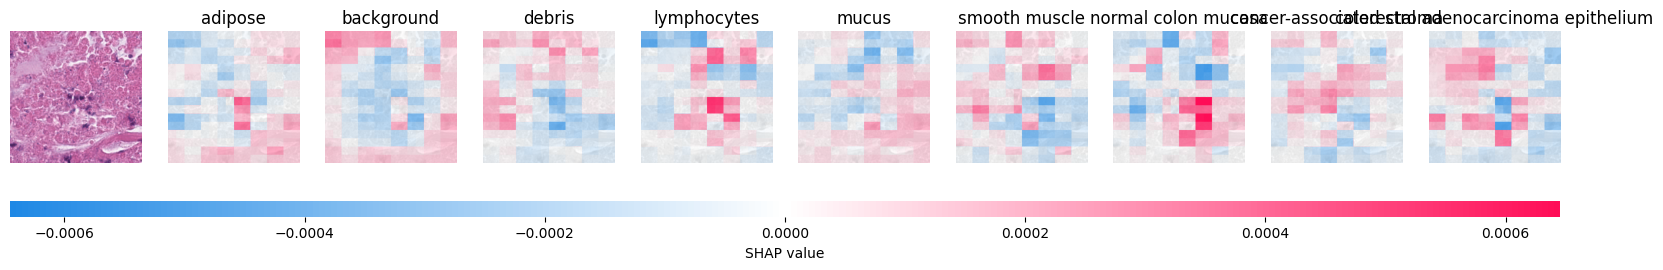

In [34]:
import shap


def f(x):
    tmp = torch.tensor(x, dtype=torch.float32)
    if tmp.shape[-1] == 3:  # If (N, H, W, C)
        tmp = tmp.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
    tmp = tmp.to(next(model.parameters()).device)  # Match model device
    return model(tmp)


masker_blur = shap.maskers.Image("blur(224,224)", test_images[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=output_names)
ind=[600]
shap_values_ = explainer( test_dataset.imgs[ind], max_evals=5000, batch_size=50)    
print("True Label: ", output_names[test_labels[ind].item()]) 
shap.image_plot(shap_values_)


TypeError: only integer scalar arrays can be converted to a scalar index

True Label:  mucus
True Label:  mucus
True Label:  colorectal adenocarcinoma epithelium
True Label:  mucus
True Label:  mucus
True Label:  colorectal adenocarcinoma epithelium
True Label:  adipose
True Label:  normal colon mucosa
True Label:  colorectal adenocarcinoma epithelium
True Label:  colorectal adenocarcinoma epithelium
True Label:  normal colon mucosa
True Label:  colorectal adenocarcinoma epithelium
True Label:  normal colon mucosa
True Label:  adipose
True Label:  smooth muscle
True Label:  adipose
True Label:  debris
True Label:  adipose
True Label:  smooth muscle


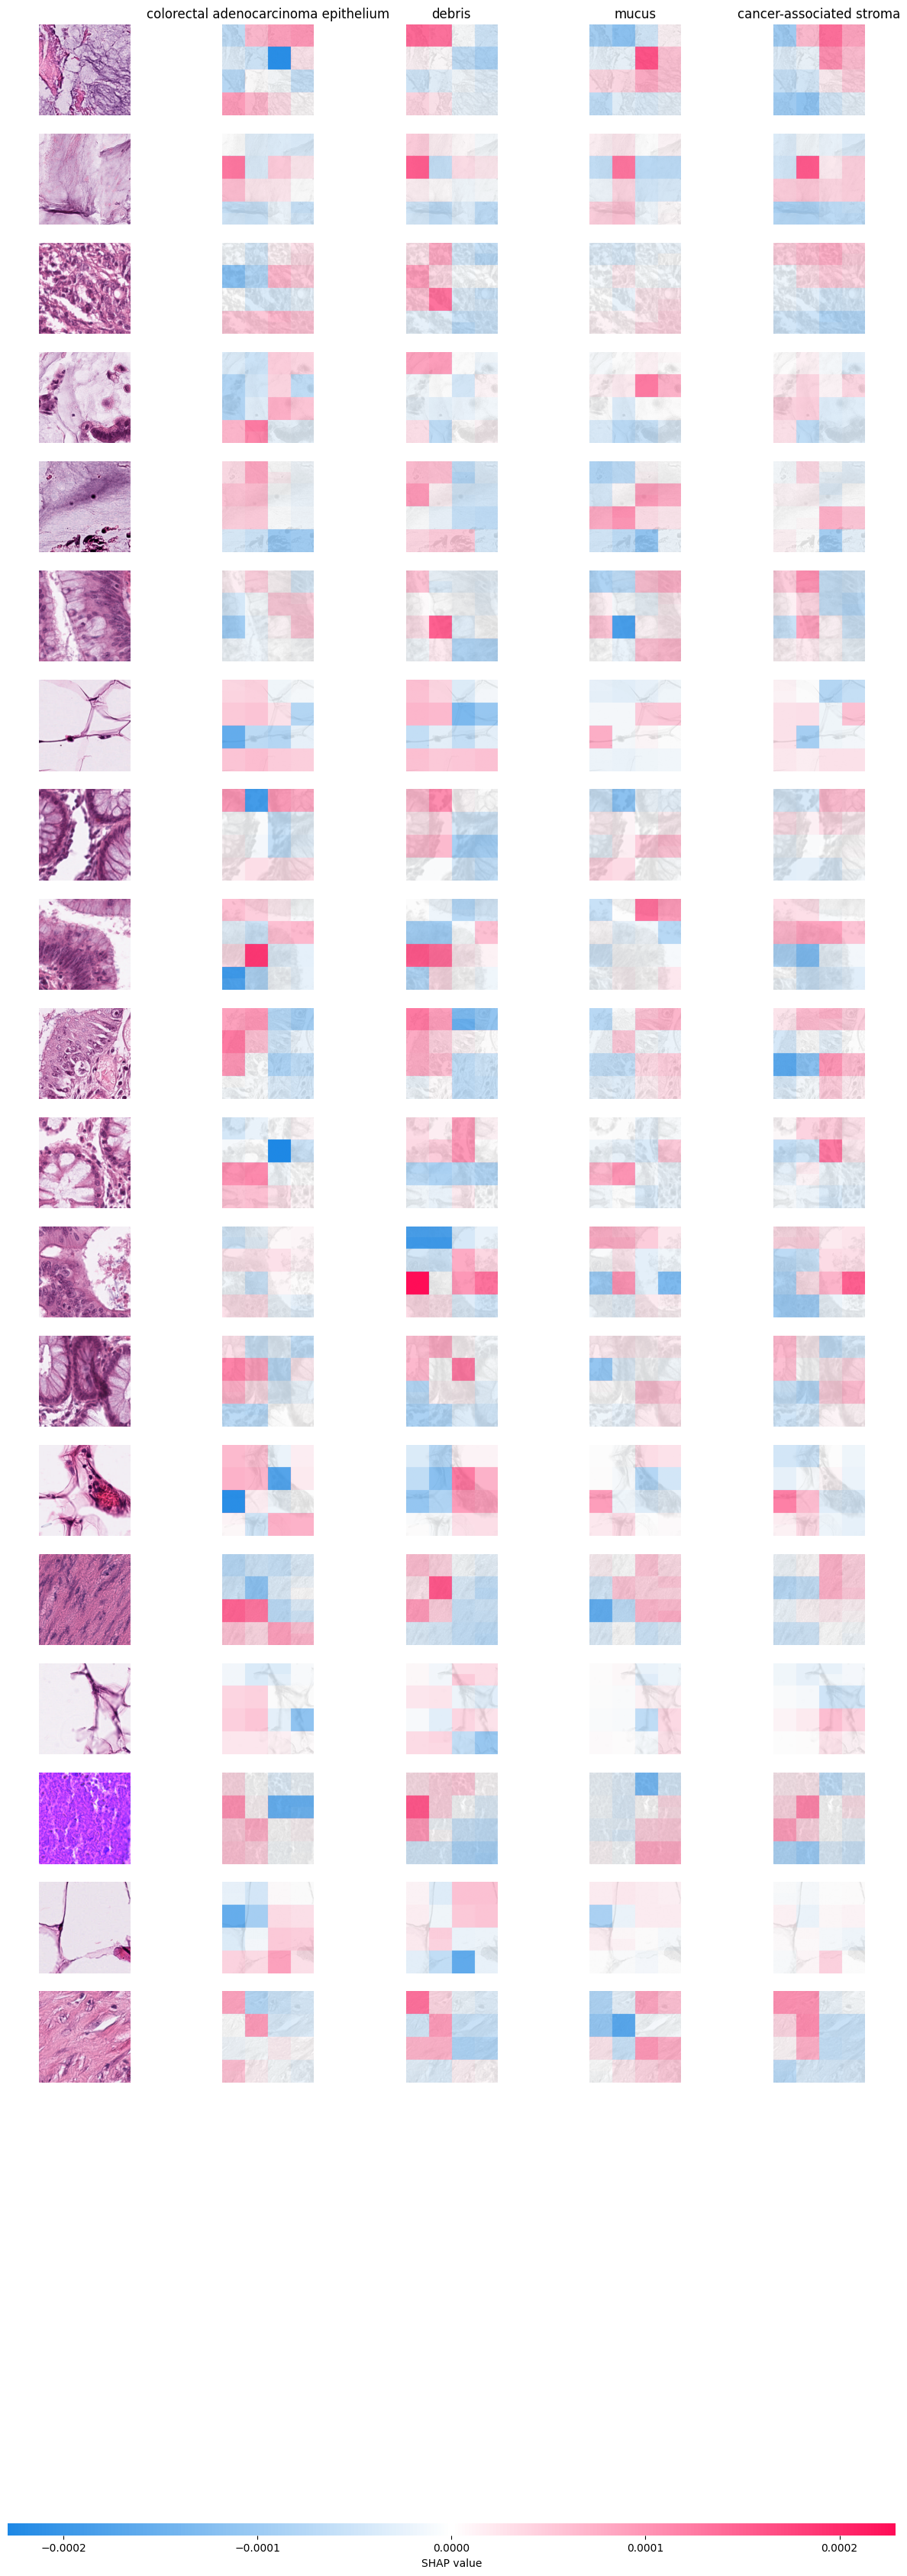

In [33]:
def f(x):
    tmp = torch.tensor(x, dtype=torch.float32)
    if tmp.shape[-1] == 3:  # If (N, H, W, C)
        tmp = tmp.permute(0, 3, 1, 2)  # Convert to (N, C, H, W)
    tmp = tmp.to(next(model.parameters()).device)  # Match model device
    return model(tmp)


# define a masker that is used to mask out partitions of the input image.
masker = shap.maskers.Image("blur(8,8)",test_images[0].shape)

# create an explainer with model and image masker
explainer = shap.Explainer(f, masker, output_names=output_names)
ind = [i for i in range(1,20)]
# here we explain two images using 500 evaluations of the underlying model to estimate the SHAP values
shap_values = explainer(test_images[ind], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:4])

for i in ind:
    print("True Label: ", output_names[test_labels[i].item()])  

shap.image_plot(shap_values,)


In [ ]:
### Currently the project scope ends here. The following is from the original sample and remains unchanged.

# We then check a 3D dataset with size 28x28x28

In [21]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 32.7M/32.7M [00:01<00:00, 18.7MB/s]


In [22]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 28, 28, 28) (1,)


In [23]:
for x, y in train_loader:
	print(x.shape, y.shape)
	break

torch.Size([128, 1, 28, 28, 28]) torch.Size([128, 1])


In [24]:
frames = train_dataset.montage(length=1, save_folder="tmp/")
frames[10]

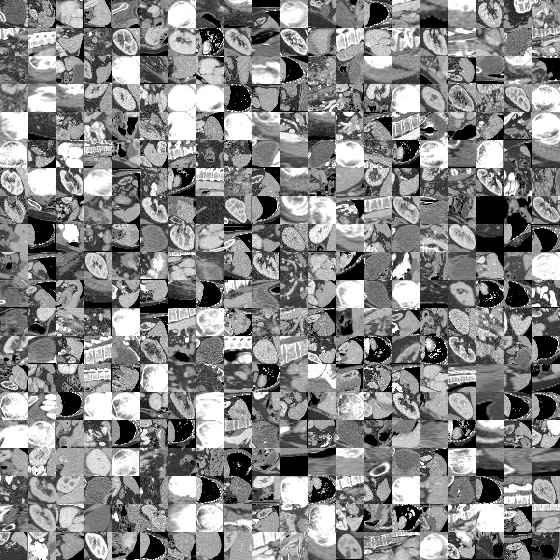

In [25]:
frames = train_dataset.montage(length=20, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_train_montage.gif) ;)

# We then check a 3D dataset with size 64x64x64

In [26]:
data_flag = 'organmnist3d'
download = True

info = INFO[data_flag]
DataClass = getattr(medmnist, info['python_class'])

# load the data
train_dataset = DataClass(split='train', download=download, size=64)

# encapsulate data into dataloader form
train_loader = data.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

100%|██████████| 361M/361M [00:12<00:00, 29.3MB/s] 


In [27]:
x, y = train_dataset[0]

print(x.shape, y.shape)

(1, 64, 64, 64) (1,)


In [28]:
for x, y in train_loader:
	print(x.shape, y.shape)
	break

torch.Size([128, 1, 64, 64, 64]) torch.Size([128, 1])


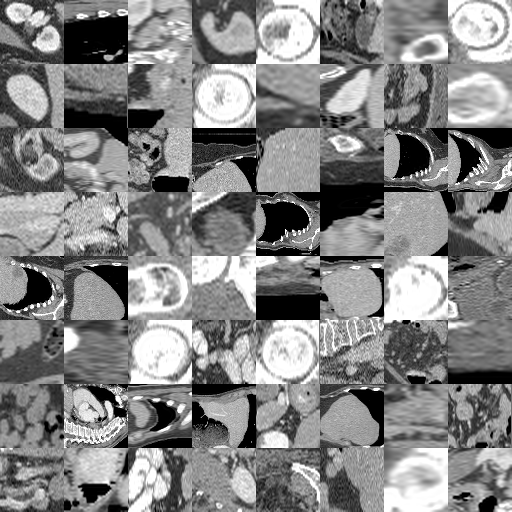

In [29]:
frames = train_dataset.montage(length=8, save_folder="tmp/")

frames[10]

## Go and check the generated [gif](tmp/organmnist3d_64_train_montage.gif) ;)

# Check [EXTERNAL] [`MedMNIST/experiments`](https://github.com/MedMNIST/experiments)

Training and evaluation scripts to reproduce both 2D and 3D experiments in our paper, including PyTorch, auto-sklearn, AutoKeras and Google AutoML Vision together with their weights ;)